## POS tagging using modified Viterbi

In this assignment, we need to modify the Viterbi algorithm to solve the problem of unknown words using at least two techniques. Though there could be multiple ways to solve this problem, we can use the following hints:<br>

1. Which tag class can be most unknown words belong to? Can we identify rules (e.g. based on morphological cues) that can be used to tag unknown words? You may define separate python functions to exploit these rules so that they work in tandem with the original Viterbi algorithm.<br>
2. Why does the Viterbi algorithm choose a random tag on encountering an unknown word? Can you modify the Viterbi algorithm so that it considers only one of the transition or emission probabilities for unknown words?

# Goals

We can split the Treebank dataset into train and validation sets. Please use a sample size of 95:5 for training: validation sets, i.e. keep the validation size small, else the algorithm will need a very high amount of runtime.<br>
 
You need to accomplish the following in this assignment:<br>

1. Write the vanilla Viterbi algorithm for assigning POS tags (i.e. without dealing with unknown words) 
2. Solve the problem of unknown words using at least two techniques. These techniques can use any of the approaches discussed in the class - lexicon, rule-based, probabilistic etc. Note that to implement these techniques, you can either write separate functions and call them from the main Viterbi algorithm, or modify the Viterbi algorithm, or both.
3. Compare the tagging accuracy after making these modifications with the vanilla Viterbi algorithm.
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications.

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [4]:
# Splitting into train and validation set in the ratio 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('New', 'NOUN'), ('York-based', 'ADJ'), ('Alleghany', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('insurance', 'NOUN'), ('and', 'CONJ'), ('financial', 'ADJ'), ('services', 'NOUN'), ('concern', 'NOUN'), ('.', '.')], [('The', 'DET'), ('ailing', 'VERB'), ('company', 'NOUN'), (',', '.'), ('which', 'DET'), ('*T*-236', 'X'), ('has', 'VERB'), ('reported', 'VERB'), ('net', 'ADJ'), ('losses', 'NOUN'), ('for', 'ADP'), ('16', 'NUM'), ('consecutive', 'ADJ'), ('quarters', 'NOUN'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('wo', 'VERB'), ("n't", 'ADV'), ('manufacture', 'VERB'), ('network', 'NOUN'), ('computer', 'NOUN'), ('systems', 'NOUN'), ('any', 'ADV'), ('more', 'ADJ'), ('and', 'CONJ'), ('will', 'VERB'), ('greatly', 'ADV'), ('reduce', 'VERB'), ('its', 'PRON'), ('costly', 'ADJ'), ('direct', 'ADJ'), ('sales', 'NOUN'), ('force', 'NOUN'), ('.', '.')], [('Ed', 'NOUN'), ('Macheski', 'NOUN'), (',', '.'), ('a', 'DET'), ('Wilton', 'NOUN'), (',', '.'), ('Conn.', 'NOUN'), (',', '.')

In [5]:
# Getting list of train tagged words and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Train tagged words -' ,len(train_tagged_words))

test_tagged_words = [tup for sent in test_set for tup in sent]
print('Test tagged words -' ,len(test_tagged_words))

Train tagged words - 95559
Test tagged words - 5117


In [6]:
#Lets check the train tagged words
train_tagged_words[:20]

[('New', 'NOUN'),
 ('York-based', 'ADJ'),
 ('Alleghany', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('insurance', 'NOUN'),
 ('and', 'CONJ'),
 ('financial', 'ADJ'),
 ('services', 'NOUN'),
 ('concern', 'NOUN'),
 ('.', '.'),
 ('The', 'DET'),
 ('ailing', 'VERB'),
 ('company', 'NOUN'),
 (',', '.'),
 ('which', 'DET'),
 ('*T*-236', 'X'),
 ('has', 'VERB'),
 ('reported', 'VERB'),
 ('net', 'ADJ')]

In [7]:
#Tokens in the train tagged words
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['New',
 'York-based',
 'Alleghany',
 'is',
 'an',
 'insurance',
 'and',
 'financial',
 'services',
 'concern']

In [8]:
#Also checking the vocabulary
vocab = set(tokens)
print(len(vocab))

12098


In [9]:
# checking the no. of tags and tags
tags = set([pair[1] for pair in train_tagged_words])
print('No.tags present in the train tagged set',len(tags))

No.tags present in the train tagged set 12


In [10]:
#Print the tags present
print(tags)

{'DET', '.', 'NOUN', 'PRON', 'CONJ', 'VERB', 'X', 'ADJ', 'ADV', 'NUM', 'ADP', 'PRT'}


### Build the vanilla Viterbi based POS tagger

*Functions for computing the emission probabilty and transition probability for given words*

In [11]:
# computing P(w/t) and storing in T x V matrix
t = len(tags)
v = len(vocab)
w_given_t = np.zeros((t, v))

In [12]:
# function to calculate emission probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# function to calculate transition probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [15]:
#printing the tag matrix
tags_matrix

array([[5.55153284e-03, 1.77407674e-02, 6.36615992e-01, 3.74125037e-03,
        4.82741976e-04, 3.91020998e-02, 4.50156890e-02, 2.07458362e-01,
        1.27926627e-02, 2.20854450e-02, 9.17209778e-03, 2.41370988e-04],
       [1.74292922e-01, 9.30463001e-02, 2.23112956e-01, 6.54836968e-02,
        5.86380847e-02, 8.79120901e-02, 2.73824539e-02, 4.42262664e-02,
        5.21527641e-02, 8.04359540e-02, 9.07944515e-02, 2.43199430e-03],
       [1.32653061e-02, 2.39905253e-01, 2.64030606e-01, 4.77405265e-03,
        4.24198247e-02, 1.46865889e-01, 2.88629737e-02, 1.18440231e-02,
        1.69460643e-02, 9.54810530e-03, 1.77332357e-01, 4.42055389e-02],
       [9.22367442e-03, 4.07378934e-02, 2.07148343e-01, 7.30207516e-03,
        4.99615679e-03, 4.84242886e-01, 9.37740207e-02, 7.57109895e-02,
        3.38201374e-02, 7.30207516e-03, 2.38278247e-02, 1.19139124e-02],
       [1.20465115e-01, 3.44186053e-02, 3.46976757e-01, 5.67441843e-02,
        4.65116289e-04, 1.56279072e-01, 8.83720908e-03, 1.20

In [16]:
#converting in dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,DET,.,NOUN,PRON,CONJ,VERB,X,ADJ,ADV,NUM,ADP,PRT
DET,0.005552,0.017741,0.636616,0.003741,0.000483,0.039102,0.045016,0.207458,0.012793,0.022085,0.009172,0.000241
.,0.174293,0.093046,0.223113,0.065484,0.058638,0.087912,0.027382,0.044226,0.052153,0.080436,0.090794,0.002432
NOUN,0.013265,0.239905,0.264031,0.004774,0.042420,0.146866,0.028863,0.011844,0.016946,0.009548,0.177332,0.044206
PRON,0.009224,0.040738,0.207148,0.007302,0.004996,0.484243,0.093774,0.075711,0.033820,0.007302,0.023828,0.011914
CONJ,0.120465,0.034419,0.346977,0.056744,0.000465,0.156279,0.008837,0.120465,0.053953,0.042791,0.053488,0.005116
VERB,0.134002,0.035075,0.111293,0.035542,0.005600,0.168844,0.216830,0.064940,0.081739,0.023021,0.090838,0.032276
X,0.053660,0.163223,0.061349,0.057024,0.010091,0.206311,0.074163,0.016979,0.026109,0.002723,0.144802,0.183566
ADJ,0.004759,0.064982,0.702166,0.000656,0.016410,0.012143,0.020348,0.066623,0.004431,0.020020,0.077125,0.010338
ADV,0.070164,0.134313,0.033411,0.015369,0.007016,0.348814,0.023388,0.126629,0.077848,0.031407,0.117942,0.013699
NUM,0.003560,0.116879,0.352714,0.001483,0.013646,0.018096,0.207357,0.034411,0.002966,0.185702,0.035301,0.027885


### Exploratory Data Analysis ###

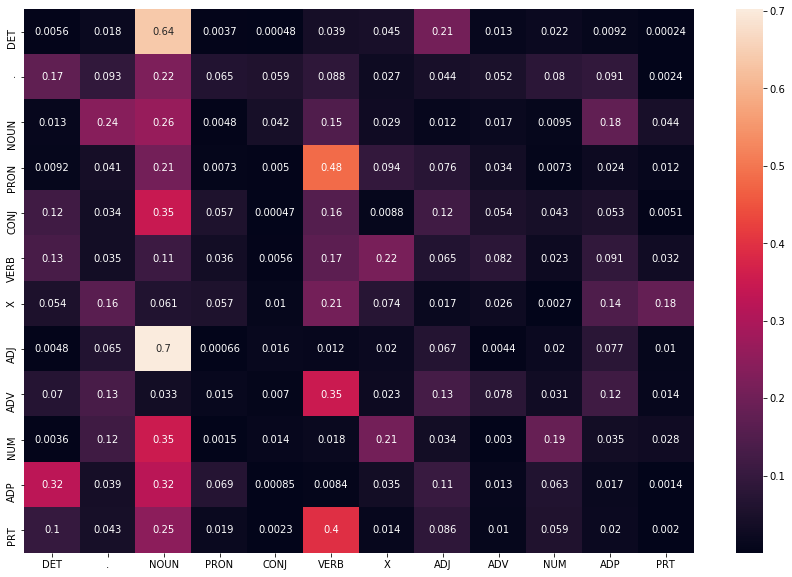

In [17]:
#Creating heat map for tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(15, 10))
sns.heatmap(tags_df,annot=True)
plt.show()

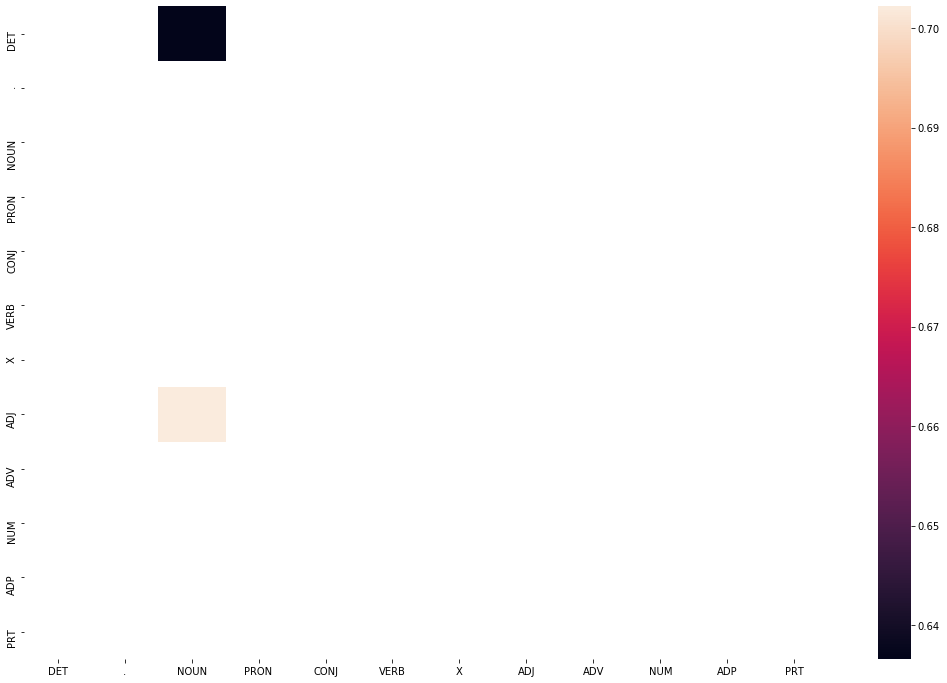

In [18]:
#Now checking the frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Viterbi Algorithm ###

Below will be the steps: <br>
1.Calculate the Probability P(w, tag) for the word sequence without dealing with the unknown words <br>
2.Compute the product of emission and transition probability <br>
3.Assign the tags which has maximum probability and calculate the same for the next word<br>


In [19]:
# Function for vanilla viterbi algorithm
def vanilla_viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [20]:
#Now evaluating the same on validation set

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('But', 'CONJ'),
  ('Coleco', 'NOUN'),
  ('bounced', 'VERB'),
  ('back', 'PRT'),
  ('with', 'ADP'),
  ('the', 'DET'),
  ('introduction', 'NOUN'),
  ('of', 'ADP'),
  ('the', 'DET'),
  ('Cabbage', 'NOUN'),
  ('Patch', 'NOUN'),
  ('dolls', 'NOUN'),
  (',', '.'),
  ('whose', 'PRON'),
  ('sales', 'NOUN'),
  ('*T*-1', 'X'),
  ('hit', 'VERB'),
  ('$', '.'),
  ('600', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('in', 'ADP'),
  ('1985', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Karns', 'NOUN'),
  ('continues', 'VERB'),
  ('as', 'ADP'),
  ('chairman', 'NOUN'),
  ('.', '.')],
 [('``', '.'),
  ('It', 'PRON'),
  ("'s", 'VERB'),
  ('an', 'DET'),
  ('odd', 'ADJ'),
  ('thing', 'NOUN'),
  ('0', 'X'),
  ('*', 'X'),
  ('to', 'PRT'),
  ('put', 'VERB'),
  ('*T*-1', 'X'),
  ('on', 'ADP'),
  ('the', 'DET'),
  ('list', 'NOUN'),
  (',', '.'),
  ("''", '.'),
  ('Mr.', 'NOUN'),
  ('Bretz', 'NOUN'),
  ('noted', 'VERB'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('William', 'NOUN'),
  ('C.', 'NOUN'),
  ('Walbr

In [21]:
#tagging the test sentences
start = time.time()
tagged_seq = vanilla_viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  30.853001356124878
[('But', 'CONJ'), ('Coleco', 'NOUN'), ('bounced', 'DET'), ('back', 'ADV'), ('with', 'ADP'), ('the', 'DET'), ('introduction', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('Cabbage', 'DET'), ('Patch', 'DET'), ('dolls', 'DET'), (',', '.'), ('whose', 'PRON'), ('sales', 'NOUN'), ('*T*-1', 'X'), ('hit', 'VERB'), ('$', '.'), ('600', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('1985', 'NUM'), ('.', '.'), ('Mr.', 'NOUN'), ('Karns', 'NOUN'), ('continues', 'VERB'), ('as', 'ADP'), ('chairman', 'NOUN'), ('.', '.'), ('``', '.'), ('It', 'PRON'), ("'s", 'VERB'), ('an', 'DET'), ('odd', 'ADJ'), ('thing', 'NOUN'), ('0', 'X'), ('*', 'X'), ('to', 'PRT'), ('put', 'VERB'), ('*T*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('list', 'NOUN'), (',', '.'), ("''", '.'), ('Mr.', 'NOUN'), ('Bretz', 'NOUN'), ('noted', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('William', 'NOUN'), ('C.', 'NOUN'), ('Walbrecher', 'DET'), ('Jr.', 'NOUN'), (',', '.'), ('an', 'DET'), ('executive

In [22]:
#Checking the Accuracy 
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
vanilla_viterbi_accuracy = len(viterbi_word_check)/len(tagged_seq)*100
print('Accuracy of Vanilla Viterbi Algo -',vanilla_viterbi_accuracy)

Accuracy of Vanilla Viterbi Algo - 86.08695652173914


**The accuracy is less , which can be due to the unknown tagged words, lets check the unknown tagged words**

In [23]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print('Total incorrect tagged words :',len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

Total incorrect tagged words : 16
[[('Coleco', 'NOUN'), (('bounced', 'DET'), ('bounced', 'VERB'))], [('bounced', 'VERB'), (('back', 'ADV'), ('back', 'PRT'))], [('the', 'DET'), (('Cabbage', 'DET'), ('Cabbage', 'NOUN'))], [('Cabbage', 'NOUN'), (('Patch', 'DET'), ('Patch', 'NOUN'))], [('Patch', 'NOUN'), (('dolls', 'DET'), ('dolls', 'NOUN'))], [('C.', 'NOUN'), (('Walbrecher', 'DET'), ('Walbrecher', 'NOUN'))], [('San', 'NOUN'), (('Francisco-based', 'DET'), ('Francisco-based', 'ADJ'))], [('Francisco-based', 'ADJ'), (('1st', 'DET'), ('1st', 'NUM'))], [('1st', 'NUM'), (('Nationwide', 'DET'), ('Nationwide', 'NOUN'))], [('chief', 'NOUN'), (('executive', 'NOUN'), ('executive', 'ADJ'))], [('its', 'PRON'), (('principal', 'NOUN'), ('principal', 'ADJ'))], [('principal', 'ADJ'), (('operating', 'NOUN'), ('operating', 'VERB'))], [(',', '.'), (('Fidelity', 'DET'), ('Fidelity', 'NOUN'))], [('Ralston', 'NOUN'), (('Purina', 'DET'), ('Purina', 'NOUN'))], [('costs', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))], [

*So now there are 22 words which are incorrectly tagged*

In [24]:
#Lets check the unkown tagged words which are present in the test set
test_vocab_set=set([t for t in test_tagged_words])
words_unknown=list(test_vocab_set - vocab)
print('Total unknown words are ',len(words_unknown))
print(words_unknown)

Total unknown words are  10
['Cabbage', '1st', 'Patch', 'Walbrecher', 'Nationwide', 'dolls', 'Fidelity', 'bounced', 'Francisco-based', 'Purina']


### Solve the problem of unknown words

In [25]:
#Lets solve the problem of unknown words with lexicon , Rule based POS tagging
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
unigram_tagger=unigram_tagger.evaluate(test_set)
print('Accuracy of Unigram tagger ', unigram_tagger)

Accuracy of Unigram tagger  0.9054133281219464


In [26]:
# checking the accuracy with bigram tagger
bigram_tagger=nltk.BigramTagger(train_set)
bigram_tagger.evaluate(test_set)

0.2108657416454954

*The accuracy of bigram tagger is quite less , so lets combine the various tagger*

In [29]:
#Combining the unigram and rule based tagger
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

**Rule based and ungram tagger**

In [32]:
rule_based_tagger = nltk.RegexpTagger(patterns)
rule_based_unigram_tagger = nltk.UnigramTagger(train_set, backoff = rule_based_tagger)
accuracy_rule_based_unigram_tagger = rule_based_unigram_tagger.evaluate(test_set)
print("The accuracy of the Unigram Tagger backed up by the RegexpTagger is", accuracy_rule_based_unigram_tagger)

The accuracy of the Unigram Tagger backed up by the RegexpTagger is 0.9054133281219464


**Rule based unigram tagger and bigram tagger**

In [35]:
bigram_tagger = nltk.BigramTagger(train_set, backoff=rule_based_unigram_tagger)
bigram_tagger.evaluate(test_set) 
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print("The accuracy of the Bigram Tagger is",accuracy_bigram_tagger)

The accuracy of the Bigram Tagger is 0.9101035763142467


**Tigram tagger with Bigram tagger in backup**

In [38]:

trigram_tagger = nltk.TrigramTagger(train_set, backoff = bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print("The accuracy of the Trigram Tagger is", accuracy_trigram_tagger)

The accuracy of the Trigram Tagger is 0.9102990033222591


*As we can see the tigram tagger Accuracy is slightly higher than the other taggers, so we will modify the viterbi algo to use this trigram tagger as a back off*

## Viterbi Modification-1

In [41]:
# use transition probability of tags when emission probability is zero in case of unknown words

def Viterbi_Vanilla_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [42]:
# tagging the test sentences
start = time.time()
tagged_seq =Viterbi_Vanilla_for_Unknown_Words(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi for Unknown Words Accuracy: ',accuracy*100)

Time taken in seconds:  28.978071928024292
Vanilla Viterbi for Unknown Words Accuracy:  92.17391304347827


In [44]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('DET', 0.08671082786550717),
 ('.', 0.11617953306334307),
 ('NOUN', 0.28715243985391226),
 ('PRON', 0.027229251038625352),
 ('CONJ', 0.022499188982722716),
 ('VERB', 0.13455561485574358),
 ('X', 0.06533136596238973),
 ('ADJ', 0.06377211984219174),
 ('ADV', 0.03132096401176237),
 ('NUM', 0.035276635377096875),
 ('ADP', 0.09792902813968334),
 ('PRT', 0.03204303100702184)]

In [45]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Vanilla_Viterbi_for_Unknown_Words_Modified(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [48]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi_for_Unknown_Words_Modified(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_viterbi_modified = len(viterbi_word_check)/len(tagged_seq) * 100
print('Modified Vanilla Viterbi for Unknown Words Accuracy: ', accuracy_viterbi_modified)

Time taken in seconds:  30.785268545150757
Modified Vanilla Viterbi for Unknown Words Accuracy:  92.17391304347827


*We can see there is a slight improvement in accuracy from ~91% to ~92%.*

## Viterbi Modifications-2

In [50]:
# A trigram tagger backed off by a rule based tagger.

def trigram_tagger(word, train_set = train_set):
    
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]

    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff = regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [53]:
# viterbi with handling for unknown words from regex tagger

def Viterbi_Trigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in vocab:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

#### Evaluating tagging accuracy

In [54]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

# accuracy
viterbi_trigram_word_check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_trigram_accuracy = len(viterbi_trigram_word_check)/len(tagged_seq) * 100
print('Modified Viterbi Trigram Tagger Accuracy: ', viterbi_trigram_accuracy)

Time taken in seconds:  75.79390668869019
Modified Viterbi Trigram Tagger Accuracy:  94.78260869565217


**As we can see there is a good increase in the accuracy which is approx 95%**

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [58]:
acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy], 
                  ['Vanilla Viterbi Modified', accuracy_viterbi_modified], 
                  ['Unigram Tagger', unigram_tagger * 100],
                  ['Unigram + RegexpTagger', accuracy_rule_based_unigram_tagger * 100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_taggvanilla_viterbier', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger', viterbi_trigram_accuracy]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,86.086957
Vanilla Viterbi Modified,92.173913
Unigram Tagger,90.541333
Unigram + RegexpTagger,90.541333
Bigram Tagger + Unigram_tagger,91.010358
Trigram Tagger + Bigram_taggvanilla_viterbier,91.029900
Viterbi + Trigram_tagger,94.782609


*The best combination through which we get the highest accuracy is for "Viterbi + Trigram_tagger"*

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [60]:
## Testing a sentence with Vanila Viterbi
sentence_test_1 = 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.'
words = word_tokenize(sentence_test_1)
tagged_seq = vanilla_viterbi(words)
print(tagged_seq)

[('Android', 'DET'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'DET'), ('OS', 'DET'), ('worldwide', 'DET'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


In [61]:
#Now test the same sentence with another modified function algorith
tagged_seq_modified = Viterbi_Trigram_Tagger(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


In [62]:
#again testing the same sentence with another modified function algorith
tagged_seq_modified = Viterbi_Vanilla_for_Unknown_Words(words)
print(tagged_seq_modified)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'NOUN'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]


In [77]:
#Now testing another sentence 
sentence_test_2 = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\s firehose.'
words_2 = word_tokenize(sentence_test_2)

In [78]:
tagged_seq = vanilla_viterbi(words_2)
print(tagged_seq)

[('Google', 'DET'), ('and', 'CONJ'), ('Twitter', 'DET'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter\\s', 'DET'), ('firehose', 'DET'), ('.', '.')]


In [79]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words_2)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter\\s', 'NOUN'), ('firehose', 'NOUN'), ('.', '.')]


In [81]:
tagged_seq_modified = Viterbi_Vanilla_for_Unknown_Words(words_2)
print(tagged_seq_modified)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter\\s', 'VERB'), ('firehose', 'X'), ('.', '.')]


In [82]:
#Now testing another sentence 
sentence_test_3 = 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.'
words_3 = word_tokenize(sentence_test_3)

In [83]:
tagged_seq = vanilla_viterbi(words_3)
print(tagged_seq)

[('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'DET'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]


In [84]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words_3)
print(tagged_seq_modified)

[('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]


In [85]:
tagged_seq_modified = Viterbi_Vanilla_for_Unknown_Words(words_3)
print(tagged_seq_modified)

[('This', 'DET'), ('is', 'VERB'), ('the', 'DET'), ('first', 'ADJ'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('to', 'PRT'), ('be', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Eastern', 'NOUN'), ('Europe', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('11th', 'ADJ'), ('time', 'NOUN'), ('that', 'ADP'), ('it', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('held', 'VERB'), ('in', 'ADP'), ('Europe', 'NOUN'), ('.', '.')]


In [73]:
#Now testing another sentence 
sentence_test_4 = 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.'
words_4 = word_tokenize(sentence_test_4)

In [74]:
tagged_seq = vanilla_viterbi(words_4)
print(tagged_seq)

[('Twitter', 'DET'), ('is', 'VERB'), ('an', 'DET'), ('online', 'DET'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'DET'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


In [75]:
tagged_seq_modified = Viterbi_Trigram_Tagger(words_4)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'VERB'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


In [76]:
tagged_seq_modified = Viterbi_Vanilla_for_Unknown_Words(words_4)
print(tagged_seq_modified)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'DET'), ('.', '.')]


*We can clearly see that new modified functions are capable of detecting the new words and tag them*

**Final Conculsion:** *Viterbi_Trigram_Tagger and Viterbi_Vanilla_for_Unknown_Words are the two modified function which are capable of detecting the unknown words that can be used for POS tagging which are not marked by NLTK dataset*